#**스마트폰 센서 데이터 기반 모션 분류**
# 단계1 : 탐색적 데이터 분석

## 0.미션

### (1) 미션1
수많은 feature들을 모두 살펴보는 것은 과도한 시간과 노력이 필요합니다. 그래서 여러분은 **선택과 집중**을 해야 합니다.
* 1) **기본 모델을 생성**한 후 **변수 중요도**를 구합니다.   
    * random forest 알고리즘 사용을 권장합니다.
* 2) **중요한 feature와 중요하지 않은 feature 상위 N개를 선정**하고, 이들을 대상으로 EDA 수행.


### (2) 미션2
다음의 case에 맞게 feature 및 feature 그룹 중요도를 기반으로 탐색적 데이터 분석을 수행하시오.
* Target을 **정적/동적 행동**으로 구분
    * 6개의 행동은 2개의 그룹(정적행동, 동적행동)으로 나뉩니다.  
    * 어떤 feature(혹은 feature 그룹)이 2개 class 그룹(정적행동, 동적행동)를 구분하는데 중요한지를 찾아보고 탐색해봅시다.


## 1.환경설정

* 세부 요구사항
    - 경로 설정 : 구글콜랩
        * 구글 드라이브 바로 밑에 project3 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### (1) 경로 설정

* 구글 드라이브 연결

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = '/content/drive/MyDrive/project3/'

### (2) 라이브러리 설치 및 불러오기

* 라이브러리 로딩

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

* 제공 함수 생성
    * 변수 중요도를 시각화할 수 있는 함수를 제공합니다.
    * 입력 :
        * importance : 트리모델의 변수 중요도(예: model.feature_importances_)
        * names : 변수 이름 목록(예 : x_train.columns
        * result_only  : 변수 중요도 순으로 데이터프레임만 return할지, 그래프도 포함할지 결정. False이면 결과 데이터프레임 + 그래프
        * topn : 중요도 상위 n개만 표시. all 이면 전체.
    * 출력 :
        * 중요도 그래프 : 중요도 내림차순으로 정렬
        * 중요도 데이터프레임 : 중요도 내림차순으로 정렬

In [ ]:
# 변수의 특성 중요도 계산하기
def plot_feature_importance(importance, names, result_only = False, topn = 'all'):
    feature_importance = np.array(importance)
    feature_name = np.array(names)

    data={'feature_name':feature_name,'feature_importance':feature_importance}
    fi_temp = pd.DataFrame(data)

    #변수의 특성 중요도 순으로 정렬하기
    fi_temp.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_temp.reset_index(drop=True, inplace = True)

    if topn == 'all' :
        fi_df = fi_temp.copy()
    else :
        fi_df = fi_temp.iloc[:topn]

    #변수의 특성 중요도 그래프로 그리기
    if result_only == False :
        plt.figure(figsize=(10,20))
        sns.barplot(x='feature_importance', y='feature_name', data = fi_df)

        plt.xlabel('importance')
        plt.ylabel('feature name')
        plt.grid()

    return fi_df

### (3) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용
    * data01_test.csv : 테스트용
    * feature.csv : feature 이름을 계층구조로 정리한 데이터

* 세부 요구사항
    * 칼럼 삭제 : data01_train.csv와 data01_test.csv 에서 'subject' 칼럼은 불필요하므로 삭제합니다.

In [ ]:
# 데이터 불러오기
train_data = pd.read_csv(path+'data01_train.csv')
test_data = pd.read_csv(path+'data01_test.csv')
feature_data=pd.read_csv(path+'features.csv')

In [ ]:
# 'subject' 칼럼 삭제
train_data = train_data.drop(columns=['subject'])
test_data = test_data.drop(columns=['subject'])

In [ ]:
# 결과 확인
train_data.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,21,STANDING
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,15,LAYING
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,11,STANDING
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,17,WALKING
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,17,WALKING_DOWNSTAIRS


In [ ]:
test_data.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
0,0.284379,-0.021981,-0.116683,-0.992490,-0.979640,-0.963321,-0.992563,-0.977304,-0.958142,-0.938850,...,-0.850065,-0.018043,0.092304,0.074220,-0.714534,-0.671943,-0.018351,-0.185733,22,SITTING
1,0.277440,-0.028086,-0.118412,-0.996620,-0.927676,-0.972294,-0.997346,-0.931405,-0.971788,-0.939837,...,-0.613367,-0.022456,-0.155414,0.247498,-0.112257,-0.826816,0.184489,-0.068699,15,STANDING
2,0.305833,-0.041023,-0.087303,0.006880,0.182800,-0.237984,0.005642,0.028616,-0.236474,0.016311,...,0.394388,-0.362616,0.171069,0.576349,-0.688314,-0.743234,0.272186,0.053101,22,WALKING
3,0.276053,-0.016487,-0.108381,-0.995379,-0.983978,-0.975854,-0.995877,-0.985280,-0.974907,-0.941425,...,-0.841455,0.289548,0.079801,-0.020033,0.291898,-0.639435,-0.111998,-0.123298,8,SITTING
4,0.271998,0.016904,-0.078856,-0.973468,-0.702462,-0.869450,-0.979810,-0.711601,-0.856807,-0.920760,...,0.214219,0.010111,0.114179,-0.830776,-0.325098,-0.840817,0.116237,-0.096615,5,STANDING


In [ ]:
feature_data.head()

,sensor,agg,axis,feature_name
0,tBodyAcc,mean(),X,tBodyAcc-mean()-X
1,tBodyAcc,mean(),Y,tBodyAcc-mean()-Y
2,tBodyAcc,mean(),Z,tBodyAcc-mean()-Z
3,tBodyAcc,std(),X,tBodyAcc-std()-X
4,tBodyAcc,std(),Y,tBodyAcc-std()-Y


## 2.데이터 분석 : 기본정보 살펴보기

### (1) 기본정보 확인하기


* **세부 요구사항**
    - 불러온 데이터의 형태, 기초통계량, 정보 등을 확인합니다.

In [ ]:
train_data.describe()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
count,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,...,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000
mean,0.274811,-0.017799,-0.109396,-0.603138,-0.509815,-0.604058,-0.628151,-0.525944,-0.605374,-0.465490,...,0.126955,-0.305883,-0.623548,0.008524,-0.001185,0.009340,-0.007099,-0.491501,0.059299,-0.054594
std,0.067614,0.039422,0.058373,0.448807,0.501815,0.417319,0.424345,0.485115,0.413043,0.544995,...,0.249176,0.322808,0.310371,0.339730,0.447197,0.608190,0.476738,0.509069,0.297340,0.278479
min,-0.503823,-0.684893,-1.000000,-1.000000,-0.999844,-0.999667,-1.000000,-0.999419,-1.000000,-1.000000,...,-0.965725,-0.979261,-0.999765,-0.976580,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.980143
25%,0.262919,-0.024877,-0.121051,-0.992774,-0.977680,-0.980127,-0.993602,-0.977865,-0.980112,-0.936067,...,-0.021610,-0.541969,-0.845985,-0.122361,-0.294369,-0.481718,-0.373345,-0.811397,-0.018203,-0.141555
50%,0.277154,-0.017221,-0.108781,-0.943933,-0.844575,-0.856352,-0.948501,-0.849266,-0.849896,-0.878729,...,0.133887,-0.342923,-0.712677,0.010278,0.005146,0.011448,-0.000847,-0.709441,0.182893,0.003951
75%,0.288526,-0.010920,-0.098163,-0.242130,-0.034499,-0.262690,-0.291138,-0.068857,-0.268539,-0.013690,...,0.288944,-0.127371,-0.501158,0.154985,0.285030,0.499857,0.356236,-0.511330,0.248435,0.111932
max,1.000000,1.000000,1.000000,1.000000,0.916238,1.000000,1.000000,0.967664,1.000000,1.000000,...,0.946700,0.989538,0.956845,1.000000,1.000000,0.998702,0.996078,0.977344,0.478157,1.000000


In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5881 entries, 0 to 5880
Columns: 562 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), object(1)
memory usage: 25.2+ MB


In [ ]:
train_data.shape

(5881, 562)

In [ ]:
train_data['Activity']

,Activity
0,STANDING
1,LAYING
2,STANDING
3,WALKING
4,WALKING_DOWNSTAIRS
...,...
5876,SITTING
5877,WALKING_UPSTAIRS
5878,LAYING
5879,WALKING_UPSTAIRS


### (2) 목표 변수 확인하기

* **세부 요구사항**
    - target인 'Activity'에 대해 단변량 분석을 수행합니다.
    - 범주의 종류, 범주별 빈도수 및 비율 등

In [ ]:
# 'Activity' 변수의 범주 종류, 빈도수 및 비율 확인
activity_counts = train_data['Activity'].value_counts()
activity_percentages = train_data['Activity'].value_counts(normalize=True) * 100

In [ ]:
# 결과 출력
print("범주 종류:\n", activity_counts.index.tolist())
print("\n범주별 빈도수:\n", activity_counts)
print("\n범주별 비율 (%):\n", activity_percentages)

범주 종류:
 ['LAYING', 'STANDING', 'SITTING', 'WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS']

범주별 빈도수:
 Activity
LAYING                1115
STANDING              1087
SITTING               1032
WALKING                998
WALKING_UPSTAIRS       858
WALKING_DOWNSTAIRS     791
Name: count, dtype: int64

범주별 비율 (%):
 Activity
LAYING                18.959361
STANDING              18.483251
SITTING               17.548036
WALKING               16.969903
WALKING_UPSTAIRS      14.589356
WALKING_DOWNSTAIRS    13.450094
Name: proportion, dtype: float64


<ipython-input-161-1c6a1da1d1af>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=train_data, x='Activity', palette='viridis')


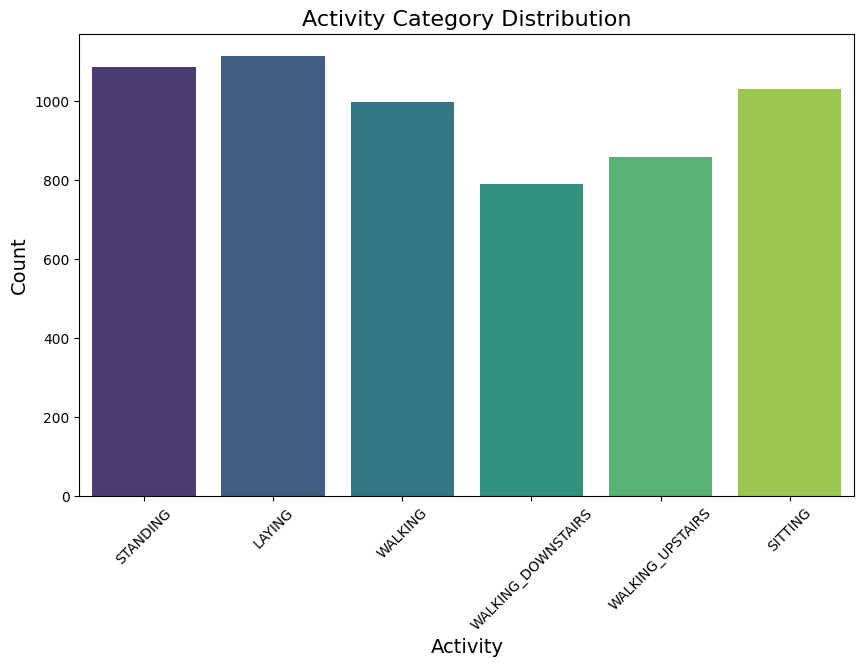

In [ ]:
# 시각화 설정
plt.figure(figsize=(10, 6))
sns.countplot(data=train_data, x='Activity', palette='viridis')

# 그래프 제목과 레이블 설정
plt.title('Activity Category Distribution', fontsize=16)
plt.xlabel('Activity', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45)  # 범주 이름 회전

# 그래프 표시
plt.show()

## 3.미션1 : 데이터 분석1

수많은 feature들을 모두 살펴보는 것은 과도한 시간과 노력이 필요합니다. 그래서 여러분은 **선택과 집중**을 해야 합니다.
* 1) **트리 모델을 생성**한 후 **변수 중요도**를 구합니다.   
    * random forest 알고리즘 사용을 권장합니다.
* 2) **중요한 feature 상위 N개를 선정**하고, 이들을 대상으로 EDA 수행.
* 3) **각 feature 그룹별 중요도**도 파악해보며 EDA를 수행  
    * Feature 이름에는 계층구조를 담고 있습니다. 그렇다 보니 feature들을 적절하게 그룹으로 묶을 수 있습니다.
    * 참고로, feature 그룹의 중요도는 개별 feature 중요도의 합으로 계산할 수 있습니다.

### (1) 기본모델링 + 변수중요도 추출

* **세부 요구사항**
    - 모델링을 위한 기본 전처리를 수행합니다.
        - 주어진 데이터에서는 x, y로 나누고 train과 validation 분할 수행
    - 트리기반 알고리즘을 이용하여 모델링을 합니다.
        - 랜덤포레스트 권장 : 랜덤포레스트는 튜닝 없이 하이퍼파리미터의 기본값로도 적절한 성능의 모델을 생성할 수 있습니다.
    - 변수 중요도 추출
        - 사용자정의함수로 생성한 plot_feature_importance 을 이용
        - 변수중요도 파악및 결과 저장

#### 1) 데이터 전처리

In [ ]:
# x, y 분리
x = train_data.drop(columns=['Activity'])
y = train_data['Activity']

In [ ]:
# train과 validation 분할
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=1)


#### 2) 모델링

In [ ]:
# 랜덤 포레스트 모델 학습
model = RandomForestClassifier(random_state=1)
model.fit(x_train, y_train)

RandomForestClassifier(random_state=1)

#### 3) 변수 중요도 추출

In [ ]:
# 변수 중요도 결과 저장
feature_importance_df = pd.DataFrame({'Feature': x.columns, 'Importance': model.feature_importances_})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
feature_importance_df.to_csv('feature_importance.csv', index=False)

In [ ]:
print(feature_importance_df)

                          Feature  Importance
558          angle(X,gravityMean)    0.039942
52            tGravityAcc-min()-X    0.033346
56         tGravityAcc-energy()-X    0.028896
40           tGravityAcc-mean()-X    0.027753
53            tGravityAcc-min()-Y    0.024392
..                            ...         ...
511           fBodyAccMag-maxInds    0.000087
108    tBodyAccJerk-arCoeff()-X,4    0.000085
285              fBodyAcc-iqr()-Y    0.000085
545    fBodyBodyGyroJerkMag-min()    0.000066
308  fBodyAcc-bandsEnergy()-49,56    0.000063

[561 rows x 2 columns]


### (2) 중요도 기반 feature 분석

* **세부 요구사항**
    - 상위 n, 하위 m 개의 변수를 선정
    - 선정된 변수(feature)와 target 간의 관계를 kdeplot으로 그리기

#### 1) 상위 5, 하위 5개 변수 선정

In [ ]:
# 상위 5개, 하위 5개 변수 선정
top_5_features = feature_importance_df.head(5)['Feature'].tolist()
bottom_5_features = feature_importance_df.tail(5)['Feature'].tolist()

In [ ]:
# 선정된 변수와 target 간의 kdeplot 시각화
def plot_kde_for_features(features, x_data, y_data, title):
    plt.figure(figsize=(10, 5))
    for feature in features:
        sns.kdeplot(x=x_data[feature], hue=y_data, fill=True, common_norm=False, alpha=0.5, label=feature)

    plt.title(title, fontsize=16)
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.show()

#### 2) 상위 5개 변수에 대한 분석

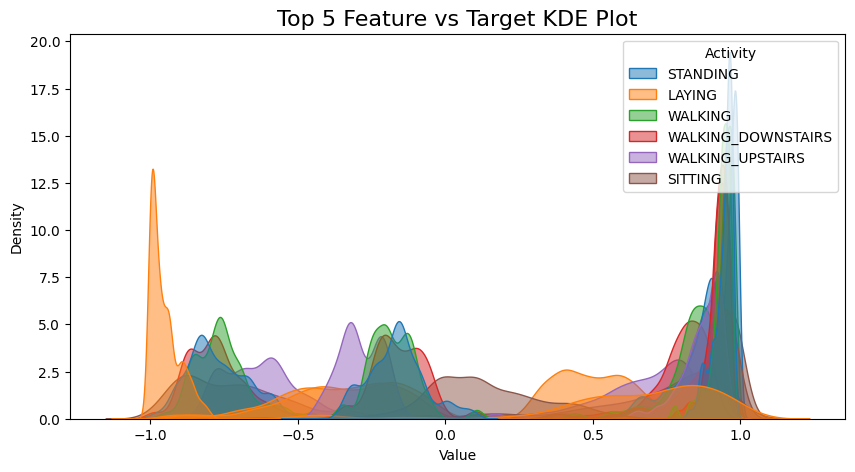

In [ ]:
# 상위 5개 변수와 target 간의 관계 시각화
plot_kde_for_features(top_5_features, x, y, 'Top 5 Feature vs Target KDE Plot')

Standing을 보면 특정 x값에서 높은 밀도를 보이고 있다. -1.0~ -0.5 / - 0.5 ~ 0.0/ 0.7~1.0 이 3구간에서 Standing 행동이 더 자주 발생

유독  -1.0~ -0.5 / - 0.5 ~ 0.0/ 0.7~1.0 이 구간에서 여러 동작들이 겹치는 부분이 많다.

이는 두가지 이상의 동작이 발생하며, Standing과 Sitting의 경우 유사한 범위에서 겹치므로 이는 두 동작의 특성이 유사하다는 것을 의미

insight: 동작 간의 분포 차이가 명확하다면 해당 feature는 모델의 예측 성능을 향상시키는데 중요

즉, 특정 동작의 밀도가 높은 영역이 명확히 구분이 된다면, 이러한 변수를 활용하면 더 나은 분류 성능이 나올 수 있음

#### 3) 하위 5개 변수에 대한 분석

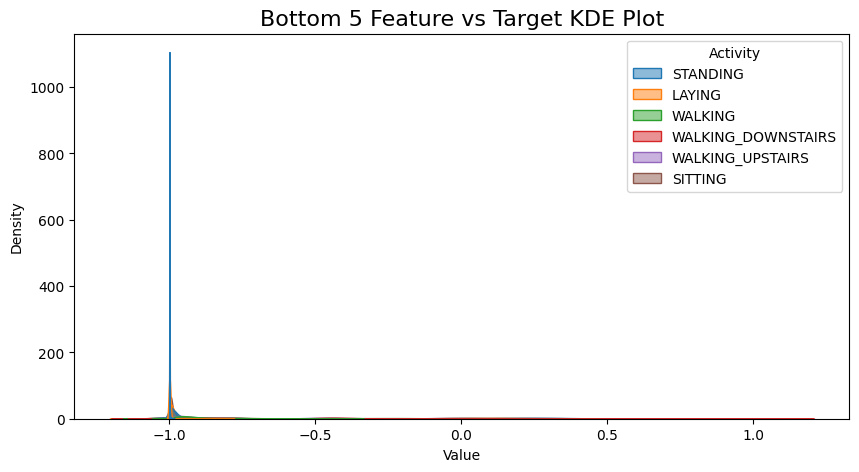

In [ ]:
# 하위 5개 변수와 target 간의 관계 시각화
plot_kde_for_features(bottom_5_features, x, y, 'Bottom 5 Feature vs Target KDE Plot')

 밀도값이 특정 값 근처에 집중되어있음

 특히 Standing에서 밀도가 유난히 높게 나타남

 LAYING, WALKING, WALKING_DOWNSTAIRS, WALKING_UPSTAIRS, SITTING은 밀도가 상대적으로 낮고, 혼합되어 있음. 이는 활동이 서로 비슷한 특성을 가지며 구분하기 어려움

## 4.미션2 : 데이터 분석2

다음의 case에 맞게 feature 및 feature 그룹 중요도를 기반으로 탐색적 데이터 분석을 수행하시오.
* Target을 **정적/동적 행동**으로 구분
    * 6개의 행동은 2개의 그룹(정적행동, 동적행동)으로 나뉩니다.  
    * 어떤 feature(혹은 feature 그룹)이 2개 class 그룹(정적행동, 동적행동)를 구분하는데 중요한지를 찾아보고 탐색해봅시다.

### (1) 정적/동적 행동으로 구분하여 분석하기

* **세부 요구사항**
    - Target인 Activity를 is_dynamic 변수로 변경하시오.
        * 값 0 : STANDING, SITTING, LAYING
        * 값 1 : WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS
    - is_dynamic을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_dynamic을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_dynamic 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_dynamic 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


#### 1) is_dynamic 추가

In [ ]:
# 1. is_dynamic 변수 생성
is_dynamic = {
    'STANDING': 0,
    'SITTING': 0,
    'LAYING': 0,
    'WALKING': 1,
    'WALKING_UPSTAIRS': 1,
    'WALKING_DOWNSTAIRS': 1
}

train_data['is_dynamic'] = train_data['Activity'].map(is_dynamic)

In [ ]:
# x, y 분리
x = train_data.drop(columns=['Activity', 'is_dynamic'])
y = train_data['is_dynamic']

# train과 validation 데이터 분할
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=1)

#### 2) 기본모델 생성

In [ ]:
# 랜덤 포레스트 모델 학습
model = RandomForestClassifier(random_state=1)
model.fit(x_train, y_train)

# 성능 평가
pred = model.predict(x_val)
print(classification_report(y_val, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       655
           1       1.00      1.00      1.00       522

    accuracy                           1.00      1177
   macro avg       1.00      1.00      1.00      1177
weighted avg       1.00      1.00      1.00      1177



#### 3) 변수중요도 상위 5개 분석

In [ ]:
# 3. 중요 변수 분석
feature_importance_df = pd.DataFrame({'Feature': x.columns, 'Importance': model.feature_importances_})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

In [ ]:
# 상위 5개 변수
top_5_features = feature_importance_df.head(5)['Feature'].tolist()
print("상위 5개 변수:", top_5_features)

상위 5개 변수: ['fBodyAccJerk-mad()-X', 'tBodyAccJerk-mad()-X', 'tBodyAccJerk-energy()-X', 'fBodyAccJerk-std()-X', 'fBodyAccJerk-bandsEnergy()-1,24']


fBody가 붙은 변수들은 **주파수 영역**에서 데이터를 분석한 결과이며, 신호의 변동성(mad), 분산(표준 편차), 에너지 등을 주파수 대역으로 나누어 측정한 것입니다.

tBody가 붙은 변수들은 **시간 영역**에서 데이터를 분석한 결과로, 가속도 변화율의 변동성이나 에너지를 시간의 흐름에 따라 분석한 값입니다.

<ipython-input-177-f76da8cb8d9e>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10), palette='viridis')


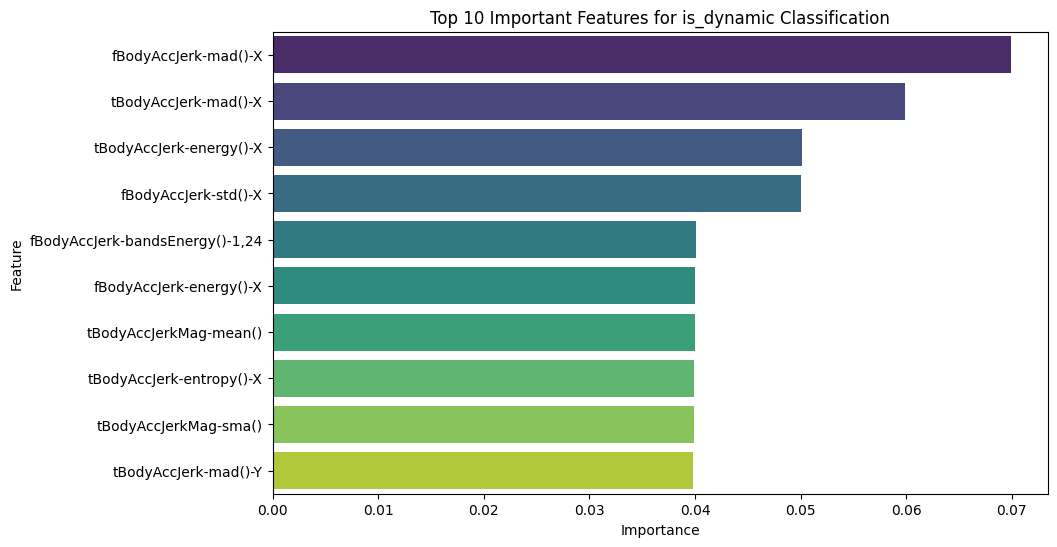

In [ ]:
# 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10), palette='viridis')
plt.title('Top 10 Important Features for is_dynamic Classification')
plt.show()


fBodyAccJerk-mad()-X,tBodyAccJerk-mad()-X,tBodyAccJerk-energy()-X,fBodyAccJerk-std()-X,fBodyAccJerk-bandsEnergy()-1,24

위 하위 6개가 값이 같은 이유


1. 모델이 특징의 중요도를 계산하는 방식이 일정 수준 이상의 차이를 명확히 구분 못하는 경우

2. 특징의 상관관계: 하위 6개의 특징이 서로 상관관계가 높거나 유사한 정보를 제공한느 경우

In [ ]:
# 4. 센서별 feature 그룹 생성 예시
sensor_features = {
    'tBodyAcc': [col for col in x.columns if 'tBodyAcc' in col],
    'tBodyGyro': [col for col in x.columns if 'tBodyGyro' in col],
    'fBodyAcc': [col for col in x.columns if 'fBodyAcc' in col],
}

In [ ]:
# 센서별 중요도 분석
sensor_importance = {}
for sensor, features in sensor_features.items():
    sensor_importance[sensor] = feature_importance_df[feature_importance_df['Feature'].isin(features)]['Importance'].sum()


<ipython-input-180-cb48fb03958b>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Sensor', data=sensor_importance_df, palette='viridis')


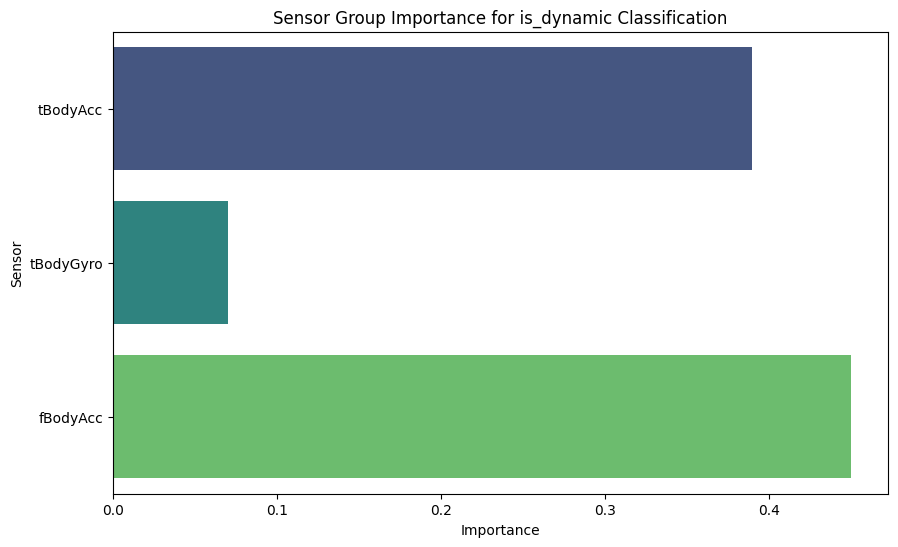

In [ ]:
# 시각화
sensor_importance_df = pd.DataFrame(sensor_importance.items(), columns=['Sensor', 'Importance'])

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Sensor', data=sensor_importance_df, palette='viridis')
plt.title('Sensor Group Importance for is_dynamic Classification')
plt.show()

fBodyAcc>tBodyAcc>tBodyGyro 순으로 중요

1. **주파수 영역의 가속도(fBodyAcc) 데이터**가 시간 영역의 가속도(tBodyAcc)보다 더 중요한 특징을 제공하고 있음을 보여줍니다.

2. 각속도(tBodyGyro) 데이터는 가속도 데이터보다 상대적으로 덜 중요한 정보로 작용할 수 있습니다. 이는 신체 활동 분석에서 회전 속도의 변화보다 가속도 변화가 더 유의미하다는 것을 나타낼 수 있습니다.

In [ ]:
# 5. 센서+집계별 분석
agg_features = {
    'tBodyAcc_mean': [col for col in x.columns if 'tBodyAcc' in col and 'mean' in col],
    'tBodyAcc_std': [col for col in x.columns if 'tBodyAcc' in col and 'std' in col],
}

agg_importance = {}
for agg, features in agg_features.items():
    agg_importance[agg] = feature_importance_df[feature_importance_df['Feature'].isin(features)]['Importance'].sum()


<ipython-input-182-6e1aee0ac205>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Aggregation', data=agg_importance_df, palette='viridis')


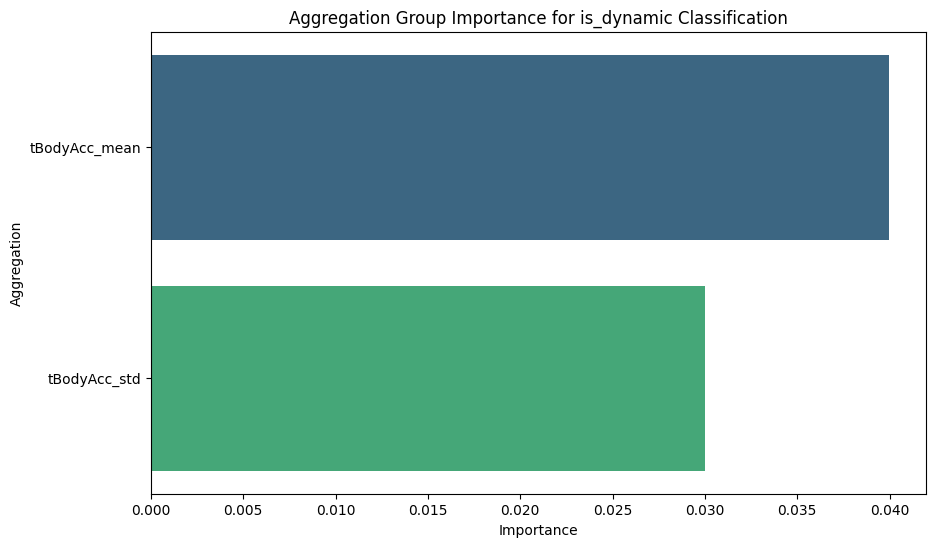

In [ ]:
# 시각화
agg_importance_df = pd.DataFrame(agg_importance.items(), columns=['Aggregation', 'Importance'])

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Aggregation', data=agg_importance_df, palette='viridis')
plt.title('Aggregation Group Importance for is_dynamic Classification')
plt.show()

tBodyAcc_mean> tBodyAcc_std

1. 이 결과는 tBodyAcc 센서(신체 가속도) 데이터에서 평균(mean) 값이 표준 편차(std) 값보다 더 중요한 특징임을 나타냅니다.

2. **평균 가속도(mean)**가 활동 분류나 예측에서 더 중요한 특징으로 작용한다는 것을 의미합니다. 이는 신체 활동의 일반적인 패턴을 분석하는 데 평균 값이 더 도움이 될 수 있음을 시사합니다.

3. 반면, **표준 편차(std)**는 변동성이나 활동의 흐트러짐을 나타내는 특징인데, 이 분석에서는 평균 값에 비해 덜 중요한 것으로 나타났습니다. 즉, 활동의 변화보다는 일반적인 움직임의 크기나 방향이 더 유의미한 정보일 수 있다는 것을 암시합니다.

## 전체적인 해석

1. **주파수 영역의 가속도(fBodyAcc)**가 가장 중요한 센서 데이터로, 주파수 영역에서 신체의 움직임 패턴을 분석하는 것이 활동 분류에 유의미합니다.
그다음으로는 **시간 영역의 가속도(tBodyAcc)**가 중요하며, 특히 평균(mean) 값이 더 중요한 특징입니다. 이는 활동의 전체적인 패턴을 잘 설명해주는 값이 평균이라는 뜻으로 해석할 수 있습니다.
2. **각속도(tBodyGyro)**는 상대적으로 덜 중요한데, 이는 신체 회전보다는 신체 가속도의 변화가 활동 분류에서 더 큰 영향을 미친다는 의미로 볼 수 있습니다.


따라서, 이 결과를 기반으로 활동 예측 모델을 최적화할 때 주파수 영역의 가속도 데이터를 중점적으로 활용하고, 시간 영역에서는 평균값을 더 중요한 특징으로 고려하는 것이 효과적일 수 있다는 결론을 내릴 수 있습니다.

## 목표: 어떤 feature(혹은 feature 그룹)이 2개 class 그룹(정적행동, 동적행동)를 구분하는데 중요한지를 찾는다

'fBodyAccJerk-mad()-X'>
'tBodyAccJerk-mad()-X'>
'tBodyAccJerk-energy()-X'>
'fBodyAccJerk-std()-X'>
'fBodyAccJerk-bandsEnergy()-1,24'

**AccJerk**는 신체의 가속도 변화율(즉, 가속도가 얼마나 빠르게 변하는지)을 나타내는데, 이는 동적 행동에서 특히 중요한 특징입니다. 동적 행동(예: 걷기, 달리기)은 가속도 변화가 큰 반면, 정적 행동(예: 서 있기, 앉아 있기)은 가속도의 변화가 상대적으로 작습니다.


이 함수들은 각각 **변동성(mad), 에너지(energy), 표준 편차(std),** 주파수 대역 에너지(bandsEnergy)를 측정합니다. 이러한 통계적 특징은 신체 활동의 규칙성, 강도, 변동성 등을 분석하는 데 중요한 역할을 합니다.
